In [1]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline

### Build an operator

(you can safely ignore this)

In [2]:
def stencil_grid(S, grid):
    N_v = np.prod(grid)  # number of vertices in the mesh
    N_s = (S != 0).sum() # number of nonzero stencil entries

    # diagonal offsets
    diags = np.zeros(N_s, dtype=int)

    # compute index offset of each dof within the stencil
    strides = np.cumprod([1] + list(reversed(grid)))[:-1]
    indices = tuple(i.copy() for i in S.nonzero())
    for i, s in zip(indices, S.shape):
        i -= s // 2

    for stride, coords in zip(strides, reversed(indices)):
        diags += stride * coords

    data = S[S != 0].repeat(N_v).reshape(N_s, N_v)

    indices = np.vstack(indices).T

    # zero boundary connections
    for index, diag in zip(indices, data):
        diag = diag.reshape(grid)
        for n, i in enumerate(index):
            if i > 0:
                s = [slice(None)] * len(grid)
                s[n] = slice(0, i)
                s = tuple(s)
                diag[s] = 0
            elif i < 0:
                s = [slice(None)]*len(grid)
                s[n] = slice(i, None)
                s = tuple(s)
                diag[s] = 0

    # remove diagonals that lie outside matrix
    mask = abs(diags) < N_v
    if not mask.all():
        diags = diags[mask]
        data = data[mask]

    # sum duplicate diagonals
    if len(np.unique(diags)) != len(diags):
        new_diags = np.unique(diags)
        new_data = np.zeros((len(new_diags), data.shape[1]),
                            dtype=data.dtype)

        for dia, dat in zip(diags, data):
            n = np.searchsorted(new_diags, dia)
            new_data[n, :] += dat

        diags = new_diags
        data = new_data

    return sparse.dia_matrix((data, diags), shape=(N_v, N_v)).tocsr()

sten = np.zeros((3,3))
sten[[0,1,1,2],[1,0,2,1]] = -1
sten[1,1] = 4

A = stencil_grid(sten, (4,4))
print(A.toarray())

[[ 4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  4.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0. -1.  4.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  4. -1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  4. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. 

### Relaxation and interpolation

Relaxation follows the 1D case, this time using $\omega = 4/5$.

Interpolation follws the 1D case, this time in tensor fashion.

In [3]:
def relax(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    Dinv = sparse.spdiags(1./A.diagonal(), [0], n, n)
    omega = 4 / 5
    
    for i in range(nu):
        unew += omega * Dinv * (f - A * unew)

    return unew

def interpolation1d(nc, nf):
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    I = np.zeros((3,nc), dtype=int)
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    return 0.5 * P

def poissonop(n):
    """
    Create a 2D operator from a stencil.
    """
    sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    A = stencil_grid(sten, (n, n))
    return A

In [4]:
n = 2**3 - 1
nc = 2**2 - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = poissonop(n)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()
P.toarray()

array([[0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  ,

### Make sure we interpolate / restrict

In [5]:
n = 2**5 - 1
nc = 2**4 - 1
A = poissonop(n)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()

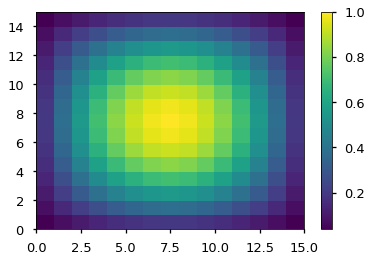

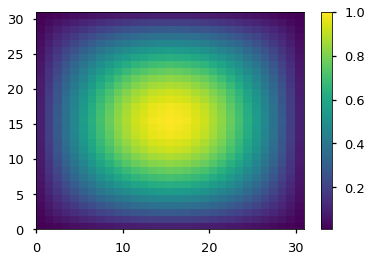

In [6]:
x1d = np.linspace(0, 1, nc+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
uc = np.sin(np.pi * X) * np.sin(np.pi * Y)
plt.figure()
plt.pcolormesh(uc)
plt.colorbar()

u = P * uc.ravel()
u = u.reshape((n,n))
plt.figure()
plt.pcolormesh(u)
plt.colorbar()

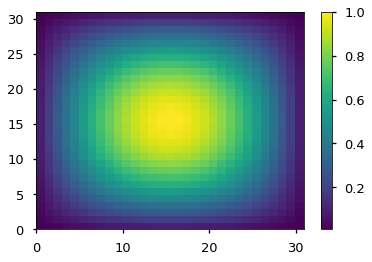

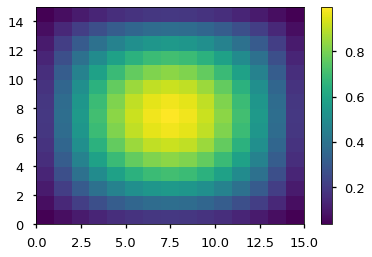

In [7]:
x1d = np.linspace(0, 1, n+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
u = np.sin(np.pi * X) * np.sin(np.pi * Y)
plt.figure()
plt.pcolormesh(u)
plt.colorbar()

uc = 0.25 * P.T * u.ravel()
uc = uc.reshape((nc,nc))
plt.figure()
plt.pcolormesh(uc)
plt.colorbar()

### Check to see if we "smooth" (visually)

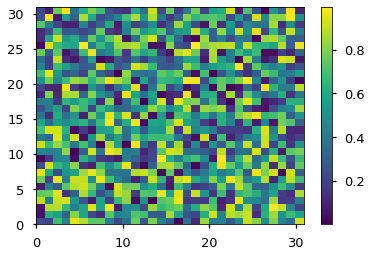

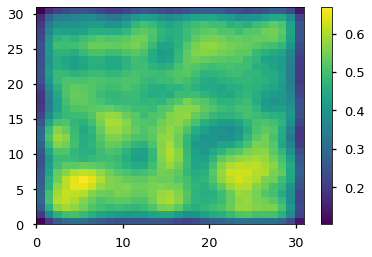

In [8]:
u = np.random.rand(n*n)
f = np.zeros((n*n,))
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()
u = relax(A, u, f, 5)
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()

In [9]:
def hnorm(r):
    """define ||r||_h = h ||r||_2"""
    n = len(r)
    h = 1.0 / (n+1)
    hrnorm = h * np.linalg.norm(r)
    return hrnorm

### Run two cycles by hand

In [10]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = poissonop(n)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()
PT = 0.25 * P.T
u0 = np.random.rand(n*n)
f0 = np.random.rand(n*n)
print('r0=', hnorm(f0 - A * u0))

u0 = relax(A, u0, f0, 1)
f1 = PT * (f0 - A * u0)
u1 = sla.spsolve(PT * A * P, f1)
u0 = u0 + P * u1
u0 = relax(A, u0, f0, 1)
print('r1=',hnorm(f0 - A * u0))

u0 = relax(A, u0, f0, 1)
f1 = PT * (f0 - A * u0)
u1 = sla.spsolve(PT * A * P, f1)
u0 = u0 + P * u1
u0 = relax(A, u0, f0, 1)
print('r2=',hnorm(f0 - A * u0))

r0= 0.04377143561583988
r1= 0.006294924435382973
r2= 0.0015314527890241214


### Construct at twogrid cycle

In [11]:
def twogrid(A, P, A1, u0, f0, nu):
    u0 = relax(A, u0, f0, nu)
    f1 = P.T * (f0 - A * u0)

    u1 = sla.spsolve(A1, f1)

    u0 = u0 + P * u1
    u0 = relax(A, u0, f0, nu)
    return u0

In [12]:
k = 7
n = 2**k - 1
nc = 2**(k-1) - 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
A = (n+1)**2 * poissonop(n)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()

x1d = np.linspace(0, 1, n+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
ustar = (X**2 - X**4) * (Y**4 - Y**2)
f = 2 * ((1-6*X**2) * Y**2 * (1 - Y**2) + (1-6*Y**2) * X**2 * (1-X**2))
f = f.ravel()
u = np.random.rand(n*n)

A1 = P.T * A * P
res = [hnorm(f - A * u)]
err = [hnorm(ustar.ravel() - u)]
for i in range(10):
    u = twogrid(A, P, A1, u, f, 1)
    res.append(hnorm(f - A * u))
    err.append(hnorm(ustar.ravel() - u))

res = np.array(res)
print(res[1:] / res[:-1])

[0.14778323 0.26855432 0.29738386 0.31186282 0.32088948 0.32717012
 0.33183843 0.33545609 0.33833754 0.34067682]
